![logo](../LogoLine_horizon_C3S.png)

# Deriving ENSO indices used in C3S graphical products from CDS data

This example shows how to compute the El Niño–Southern Oscillation (ENSO) indices used in [C3S seasonal graphical products](https://climate.copernicus.eu/charts/packages/c3s_seasonal/), from ERA5 SST data retrieved from the CDS. This is also shown for one seasonal real-time forecast system, computing the ENSO indices over the hindcast period.

In a complementary Notebook, the indices prepared here will be used to compute the correlation heatmaps displayed for the SST indices on the [verification page](https://confluence.ecmwf.int/display/CKB/C3S+seasonal+forecasts+verification+plots). 

Some information on ENSO impacts in Europe can be found on [a page in the C3S documentation](https://confluence.ecmwf.int/display/COPSRV/ENSO+impacts+on+Europe).

## Configuration

Import required modules and configure the CDS API client. Define a dictionary of C3S seasonal real-time forecast systems and versions to use.

**Note that the URL and KEY need to be filled in with the details from your CDS account, and the [cdsapi package](https://cds.climate.copernicus.eu/how-to-api) needs to be installed.** Ideally, a `.cdsapirc` file should be created, to avoid the possibility of exposing credentials when sharing Notebooks. CDS API requests can now also be made using earthkit, as shown in [this example](https://earthkit-data.readthedocs.io/en/latest/examples/cds.html).

In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import regionmask
import cdsapi
import os

# Need to leave this blank and the user needs to enter their url and key here
URL = 'https://cds.climate.copernicus.eu/api'
KEY = '' # INSERT CDS KEY HERE
c = cdsapi.Client(url=URL, key=KEY) # if a .cdsapirc file is used, url and key can be omitted

# library of C3S systems and useful parameters
# these are the latest system versions, but the previous Met Office version is used to avoid gaps in the hindcast starts
providers = {
    'ecmwf.s51': {'plot_name': 'ECMWF', 'plot_system': 'SEAS5', 'lagged': False},
    'meteo_france.s9': {'plot_name': 'Météo-France', 'plot_system': 'System 9', 'lagged': False},
    'ukmo.s603': {'plot_name': 'Met Office', 'plot_system': 'GloSea6', 'lagged': True, 'max_hc': 50, 'max_fc': 'none'},
    'dwd.s22': {'plot_name': 'DWD', 'plot_system': 'GCFS2.2', 'lagged': False},
    'cmcc.s4': {'plot_name': 'CMCC', 'plot_system': 'SPS4', 'lagged': False},
    'ncep.s2': {'plot_name': 'NCEP', 'plot_system': 'CFSv2', 'lagged': True, 'max_hc': 20, 'max_fc': 52},
    'jma.s3': {'plot_name': 'JMA', 'plot_system': 'CPS3', 'lagged': True, 'max_hc': 'none', 'max_fc': 55},
    'eccc.s4': {'plot_name': 'ECCC', 'plot_system': 'CanESM5.1p1bc', 'lagged': False},
    'eccc.s5': {'plot_name': 'ECCC', 'plot_system': 'GEM5.2-NEMO', 'lagged': False},
    'bom.s2': {'plot_name': 'BOM', 'plot_system': 'ACCESS-S2', 'lagged': False},
}

## Define ENSO regions

Define some characteristics of the SST indices to calculate for this example. Then create a `regionmask` object based on them. For further details see the [regionmask package documentation](https://regionmask.readthedocs.io/en/stable/).

In [2]:
nino_bboxes = list()
nino_bboxes.append(np.array([[270, -10], [270, 0], [280, 0], [280, -10]]))  # NINO12
nino_bboxes.append(np.array([[210, -5], [210, 5], [270, 5], [270, -5]]))  # NINO3
nino_bboxes.append(np.array([[190, -5], [190, 5], [240, 5], [240, -5]]))  # NINO34
nino_bboxes.append(np.array([[160, -5], [160, 5], [210, 5], [210, -5]]))  # NINO4

names = ["NINO1+2", "NINO3", "NINO3.4", "NINO4"]
abbrevs = [n.split("NINO")[1] for n in names]

ind_defs = regionmask.Regions(nino_bboxes, names=names, abbrevs=abbrevs, name="NINO")

Plot the defined regions to check everything is working as expected.

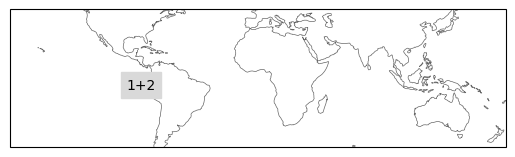

In [3]:
# plot one by one due to overlaps
ax = ind_defs[["NINO1+2"]].plot(label='abbrev')
ax.set_extent([-180, 180, -50, 50], crs=ccrs.PlateCarree())

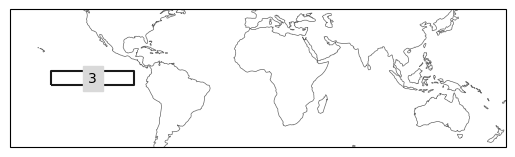

In [4]:
ax = ind_defs[["NINO3"]].plot(label='abbrev')
ax.set_extent([-180, 180, -50, 50], crs=ccrs.PlateCarree())

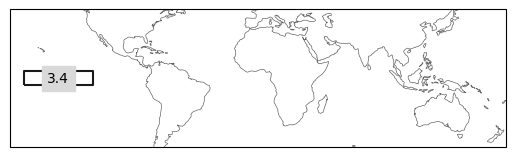

In [5]:
ax = ind_defs[["NINO3.4"]].plot(label='abbrev')
ax.set_extent([-180, 180, -50, 50], crs=ccrs.PlateCarree())

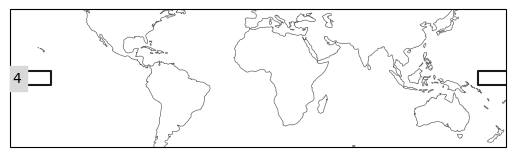

In [6]:
# note that the package deals with the wrapping of the coordinates
ax = ind_defs[["NINO4"]].plot(label='abbrev')
ax.set_extent([-180, 180, -50, 50], crs=ccrs.PlateCarree())

Note that the region mask package assigns a number to each region, which is the integer used in the mask.

## ERA5 CDS API request

Define the directory where the data will be saved. Set request details to be used by the API requests, and perform the API request.

The CDS API keywords used are:

**Product type**: `monthly_averaged_reanalysis`<br>
**Variable**: `sea_surface_temperature` <br>
**Year**: `1993 to 2016` *the common hindcast period* <br>
**Month**: `01 to 12` *all months* <br>
**Time**: `00:00` *the only option for monthly means* <br>
**Format**: `grib` <br>
**Download format**: `unarchived` *returned file is not zipped*<br>

In [7]:
data_path = 'data'

dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": ["sea_surface_temperature"],
    "year": [
        "1993", "1994", "1995",
        "1996", "1997", "1998",
        "1999", "2000", "2001",
        "2002", "2003", "2004",
        "2005", "2006", "2007",
        "2008", "2009", "2010",
        "2011", "2012", "2013",
        "2014", "2015", "2016"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "grib",
    "download_format": "unarchived"
}

print(data_path + '/era5_monthly_sst_hc_period.grib')
c.retrieve(dataset, request, data_path + '/era5_monthly_sst_hc_period.grib')

2025-11-17 08:20:43,466 INFO Request ID is 7ea8bd50-21ca-4f5d-a1c4-4301599ad45c
2025-11-17 08:20:43,527 INFO status has been updated to accepted


data/era5_monthly_sst_hc_period.grib


2025-11-17 08:20:56,893 INFO status has been updated to running
2025-11-17 08:21:04,509 INFO status has been updated to successful


b5e3df1320fd5656b99e5e0205a0224c.grib:   0%|          | 0.00/413M [00:00<?, ?B/s]

'data/era5_monthly_sst_hc_period.grib'

## Compute ERA5 indices and save

Load the data into xarray. Then define a mask using the `mask_3D_frac_approx` function, which deals with fractional overlap between the defined regions and grid cells (indicating how much of the grid cell is covered by the region). This helps to create more exact regional means.

Then, apply the mask and compute the cell-weighted area average.

In [ ]:
# read in data
sst_data = xr.open_dataarray(data_path + '/era5_monthly_sst_hc_period.grib', engine='cfgrib')
sst_data = sst_data.rename({'longitude': 'lon','latitude': 'lat'})

# apply the mask and compute area average
sst_data_mask = ind_defs.mask_3D_frac_approx(sst_data)
weights = np.cos(np.deg2rad(sst_data.lat))
sst_inds = sst_data.weighted(sst_data_mask * weights).mean(dim=("lat", "lon"))

Inspect the data objects that were just used and produced.

In [9]:
sst_data

<xarray.DataArray 'sst' (time: 288, lat: 721, lon: 1440)> Size: 1GB
array([[[271.45972, 271.45972, ..., 271.45972, 271.45972],
        [271.45972, 271.45972, ..., 271.45972, 271.45972],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[271.45972, 271.45972, ..., 271.45972, 271.45972],
        [271.45972, 271.45972, ..., 271.45972, 271.45972],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       ...,

       [[271.46045, 271.46045, ..., 271.46045, 271.46045],
        [271.46045, 271.46045, ..., 271.46045, 271.46045],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[271.46045, 271.46045, ..., 271.46045, 271.46045],
        [271.46045, 271.46045, ..., 271.46045, 271.46045],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]]], dtype=float32)
Coordinates:
    number      int64 8B 0
  * time        (time) datetime64[ns] 2kB 1993-01-01 1993-02-01 ... 2016-12-01
    step        timedelta64[ns] 8B 00:00:00
    surface     float64 8B 0.0
  * lat         (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon         (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    valid_time  (time) datetime64[ns] 2kB 1993-01-01 1993-02-01 ... 2016-12-01
Attributes: (12/30)
    GRIB_paramId:                             34
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_name:                                Sea surface temperature
    GRIB_shortName:                           sst
    GRIB_units:                               K
    long_name:                                Sea surface temperature
    units:                                    K
    standard_name:                            unknown

In [10]:
sst_inds

<xarray.DataArray 'sst' (time: 288, region: 4)> Size: 9kB
array([[297.40361302, 298.71589459, 299.96271057, 301.79814443],
       [299.43700675, 299.51221943, 300.0285691 , 301.45587454],
       [300.28422079, 300.61804533, 300.77114741, 301.62494208],
       ...,
       [294.24928403, 297.79543546, 299.31767409, 301.46601963],
       [294.64010894, 297.69924189, 299.36025281, 301.37185368],
       [295.90601987, 297.84555784, 299.31758122, 301.42310519]])
Coordinates:
    number      int64 8B 0
  * time        (time) datetime64[ns] 2kB 1993-01-01 1993-02-01 ... 2016-12-01
    step        timedelta64[ns] 8B 00:00:00
    surface     float64 8B 0.0
    valid_time  (time) datetime64[ns] 2kB 1993-01-01 1993-02-01 ... 2016-12-01
  * region      (region) int64 32B 0 1 2 3
    abbrevs     (region) <U3 48B '1+2' '3' '3.4' '4'
    names       (region) <U7 112B 'NINO1+2' 'NINO3' 'NINO3.4' 'NINO4'

Now save the indices.

In [11]:
file_name = '/era_5_nino_ind_1993_2016.nc'
if os.path.exists(data_path + file_name):
    os.remove(data_path + file_name)

sst_inds.to_netcdf(data_path + file_name, mode='w')

## Hindcast CDS API request

Set request details to be used by the API requests, and perform the API request.

In [12]:
# select a system and version
prov = 'ukmo.s603'
import re
match = re.match(r'(.+)\.s(\d+)', prov)
centre = match.group(1)
version = match.group(2)
lagged = providers[prov]['lagged']

The CDS API keywords used are:

**Originating centre**: `meteo_france`<br>
**System**: `9`<br>
**Product type**: `monthly_mean`<br>
**Variable**: `sea_surface_temperature` <br>
**Year**: `1993 to 2016` *the common hindcast period* <br>
**Month**: `01 to 12` *all start months selected one by one* <br>
**Leadtime month**: `1 to 6` *all lead months available* <br>
**Format**: `grib` <br>
**Download format**: `unarchived` *returned file is not zipped*<br>

The for loop is used to request and save each start month one by one.

In [13]:
start_mons = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]
hc_period = ['1993', '2016']
hc_str = '_'.join([hc_period[0], hc_period[1]])

In [14]:
# loop over the starts to download
for st_mon in start_mons:
    dataset = "seasonal-monthly-single-levels"
    request = {
        "originating_centre": centre,
        "system": version,
        "variable": ["sea_surface_temperature"],
        "product_type": ["monthly_mean"],
        "year": [
            "1993", "1994", "1995",
            "1996", "1997", "1998",
            "1999", "2000", "2001",
            "2002", "2003", "2004",
            "2005", "2006", "2007",
            "2008", "2009", "2010",
            "2011", "2012", "2013",
            "2014", "2015", "2016"
        ],
        "month": st_mon,
        "leadtime_month": [
            "01", "02", "03",
            "04", "05", "06"],
        "data_format": "grib"
    }

    fn = data_path + '/{}_mm_{}_{}_{}_st_{}.grib'.format('sst', centre, version, hc_str, st_mon)
    print(fn)
    c.retrieve(dataset, request, fn)

2025-11-17 08:23:05,502 INFO Request ID is d832531c-6f51-4ae3-99a1-42e09fe49e56


data/sst_mm_ukmo_603_1993_2016_st_1.grib


2025-11-17 08:23:05,541 INFO status has been updated to accepted
2025-11-17 08:23:18,912 INFO status has been updated to running
2025-11-17 08:23:26,534 INFO status has been updated to successful


56a971e022f468d0246ad97c26e38323.grib:   0%|          | 0.00/372M [00:00<?, ?B/s]

2025-11-17 08:23:28,528 INFO Request ID is fa5fc7f0-6348-40fb-9cf6-7119b2e90e38


data/sst_mm_ukmo_603_1993_2016_st_2.grib


2025-11-17 08:23:28,652 INFO status has been updated to accepted
2025-11-17 08:23:41,978 INFO status has been updated to successful


6f8a5fcac213fd4e9a38d86611fe120b.grib:   0%|          | 0.00/389M [00:00<?, ?B/s]

2025-11-17 08:23:44,008 INFO Request ID is adf004ee-ca3e-4489-94cd-1c76929bdab1
2025-11-17 08:23:44,084 INFO status has been updated to accepted


data/sst_mm_ukmo_603_1993_2016_st_3.grib


2025-11-17 08:23:52,320 INFO status has been updated to running
2025-11-17 08:23:57,505 INFO status has been updated to successful


6721b8dc32368132a393d1d54e05454.grib:   0%|          | 0.00/389M [00:00<?, ?B/s]

2025-11-17 08:23:59,757 INFO Request ID is e034d43e-f415-481f-9bd2-1564c239ed42
2025-11-17 08:23:59,780 INFO status has been updated to accepted


data/sst_mm_ukmo_603_1993_2016_st_4.grib


2025-11-17 08:24:13,347 INFO status has been updated to successful


f3b07ee96731839edb3e4545d396765d.grib:   0%|          | 0.00/389M [00:00<?, ?B/s]

2025-11-17 08:24:15,473 INFO Request ID is 218f3dd6-732f-4e6b-ae7e-201c6f769350


data/sst_mm_ukmo_603_1993_2016_st_5.grib


2025-11-17 08:24:15,730 INFO status has been updated to accepted
2025-11-17 08:24:29,060 INFO status has been updated to successful


36b962e80904d27a40bb0434da7d07b4.grib:   0%|          | 0.00/389M [00:00<?, ?B/s]

2025-11-17 08:24:31,241 INFO Request ID is 10eb7719-82c8-4457-a4da-94acb4319dad
2025-11-17 08:24:31,280 INFO status has been updated to accepted


data/sst_mm_ukmo_603_1993_2016_st_6.grib


2025-11-17 08:24:39,526 INFO status has been updated to running
2025-11-17 08:24:44,615 INFO status has been updated to successful


f6372b3c7172621a595997a8ea1b7513.grib:   0%|          | 0.00/389M [00:00<?, ?B/s]

2025-11-17 08:24:46,924 INFO Request ID is ad6fd554-2b49-4c41-b124-ed39afc99234
2025-11-17 08:24:46,962 INFO status has been updated to accepted


data/sst_mm_ukmo_603_1993_2016_st_7.grib


2025-11-17 08:25:00,323 INFO status has been updated to running
2025-11-17 08:25:07,937 INFO status has been updated to successful


8272d2dffe7ce4bb51ea418bf8cda34b.grib:   0%|          | 0.00/389M [00:00<?, ?B/s]

2025-11-17 08:25:10,009 INFO Request ID is 9741646c-acda-4969-adf6-3a7004d0fc2e
2025-11-17 08:25:10,026 INFO status has been updated to accepted


data/sst_mm_ukmo_603_1993_2016_st_8.grib


2025-11-17 08:25:23,337 INFO status has been updated to running
2025-11-17 08:25:30,968 INFO status has been updated to successful


cd4739059427778265b1641b5a44b353.grib:   0%|          | 0.00/389M [00:00<?, ?B/s]

2025-11-17 08:25:33,342 INFO Request ID is 61987e80-39e7-4007-bb5b-576e18d24b66


data/sst_mm_ukmo_603_1993_2016_st_9.grib


2025-11-17 08:25:33,360 INFO status has been updated to accepted
2025-11-17 08:25:46,723 INFO status has been updated to running
2025-11-17 08:25:54,357 INFO status has been updated to successful


6e2da6eb0850883f1070455fafdf1a59.grib:   0%|          | 0.00/389M [00:00<?, ?B/s]

data/sst_mm_ukmo_603_1993_2016_st_10.grib


2025-11-17 08:25:56,756 INFO Request ID is a8d59f22-51fc-4933-9993-6d35b63e10b7
2025-11-17 08:25:56,785 INFO status has been updated to accepted
2025-11-17 08:26:10,181 INFO status has been updated to successful


848dfcc35cef546d00e6a66cf710700e.grib:   0%|          | 0.00/389M [00:00<?, ?B/s]

2025-11-17 08:26:12,756 INFO Request ID is 45c028bf-1eac-4d20-9c18-574c8dd0a25a
2025-11-17 08:26:12,773 INFO status has been updated to accepted


data/sst_mm_ukmo_603_1993_2016_st_11.grib


2025-11-17 08:26:26,098 INFO status has been updated to successful


17e866f608203abd257a9cebc112c81f.grib:   0%|          | 0.00/389M [00:00<?, ?B/s]

2025-11-17 08:26:28,579 INFO Request ID is 5489361e-018e-41bd-b266-86511b5b9286
2025-11-17 08:26:28,597 INFO status has been updated to accepted


data/sst_mm_ukmo_603_1993_2016_st_12.grib


2025-11-17 08:26:36,831 INFO status has been updated to running
2025-11-17 08:26:41,924 INFO status has been updated to successful


7f9a26ee0dfb71c317ea7738af94ff33.grib:   0%|          | 0.00/389M [00:00<?, ?B/s]

## Compute hindcast indices and save

Loop over each start month, read the data, then as before, define a mask using the `mask_3D_frac_approx` function. Apply the mask and compute the cell-weighted area average, and save the data.

In [16]:
# For the re-shaping of time coordinates in xarray.Dataset we need to select the right one 
#  -> burst mode ensembles (e.g. ECMWF SEAS5) use "time". 
#  -> lagged start ensembles (e.g. Met Office GloSea6) use "indexing_time" (see documentation about nominal start date)
if lagged:
    st_dim_name = 'indexing_time'
else:
    st_dim_name = 'time' 

# loop over the starts to read data and compute indices
for st_mon in start_mons:
    # read in data
    fn = data_path + '/{}_mm_{}_{}_{}_st_{}.grib'.format('sst', centre, version, hc_str, st_mon)
    sst_data = xr.open_dataarray(fn, engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', st_dim_name)))
    sst_data = sst_data.rename({'longitude': 'lon','latitude': 'lat', st_dim_name:'start_date'})
    # sst_data = sst_data.reindex(lat=sst_data.lat[::-1])

    ind_defs = regionmask.Regions(nino_bboxes, names=names, abbrevs=abbrevs, name="NINO")

    sst_data_mask = ind_defs.mask_3D_frac_approx(sst_data)
    weights = np.cos(np.deg2rad(sst_data.lat))
    sst_inds = sst_data.weighted(sst_data_mask * weights).mean(dim=("lat", "lon"))

    # save the indices
    file_name = '/{}_mm_{}_{}_{}_st_{}_nino_ind.nc'.format('sst', centre, version, hc_str, st_mon)
    if os.path.exists(data_path + file_name):
        os.remove(data_path + file_name)
    print('saving sst_inds for start: ', st_mon)
    sst_inds.to_netcdf(data_path + file_name, mode='w')

saving sst_inds for start:  1
saving sst_inds for start:  2
saving sst_inds for start:  3
saving sst_inds for start:  4
saving sst_inds for start:  5
saving sst_inds for start:  6
saving sst_inds for start:  7
saving sst_inds for start:  8
saving sst_inds for start:  9
saving sst_inds for start:  10
saving sst_inds for start:  11
saving sst_inds for start:  12


The NINO index data saved for both ERA5 and the hindcasts from the example system are used in a follow-up Notebook to compute the temporal correlation between the hindcast mean and ERA5, and then construct correlation heatmaps (as shown on the [verification page](https://confluence.ecmwf.int/display/CKB/C3S+seasonal+forecasts+verification+plots) in the documentation).